In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

sns.set_theme()
sns.set_style("white")

df = pd.read_csv("../../out/results/2023-06-25-00-39-58_GAT_LOOCV.csv", low_memory=False)

with open("../../data/donor_name_map.json", mode="r") as f:
    donor_names = json.load(f)
df["Donor ID"] = df["Donor ID"].map(donor_names)

# Processing is required for the Race column
df["Race"] = np.select(
    condlist=[
        df["specify other race"] == "Mixed",
        df["Race (choice=Asian)"] == "Checked",
        df["Race (choice=White)"] == "Checked",
    ],
    choicelist=[
        "Mixed",
        "Asian",
        "White",
    ],
    default="Other",
)

In [4]:
# Collapse to a row per donor
ddf = df.groupby([
    "Donor ID", 
    "Label",
    "Age at Death",
    "Sex", 
    "Race",
    "Highest level of education",
    "APOE4 Status",
    "LATE",
    "Braak", 
    "Thal", 
    "Overall AD neuropathological Change",
    "Highest Lewy Body Disease",
])["accuracy"].mean().reset_index()

ddf.rename(columns={
    "accuracy": "Accuracy",
    "Donor ID": "Donor",
    "Age at Death": "Death age", 
    # "Age of Dementia diagnosis": "Dx age",
    "APOE4 Status": "APOE4",
    # "Last CASI Score": "CASI",
    "Overall AD neuropathological Change": "ADNC",
    "Highest Lewy Body Disease": "Lewy Bodies",
    "Highest level of education": "Education",
    }, inplace=True)

ddf.set_index("Donor", inplace=True)

# ddf.sort_values(by=["Braak"], inplace=True)
ddf.sort_values(by=["Label", "Accuracy"], inplace=True, ascending=False)
ddf["Accuracy"] = ddf["Accuracy"].apply(lambda x: f"{x:.3f}")

# ddf.drop(columns=["Label"], inplace=True)  # Just required to sort

# We re-map some of the values to make them more readable
ddf["Braak"] = ddf["Braak"].map({
    "Braak IV": "IV", 
    "Braak V": "V", 
    "Braak VI": "VI",
    "Braak II": "II",
    "Braak III": "III",
    "Braak I": "I",
    "Braak 0": "0",
})
ddf["Thal"] = ddf["Thal"].map({
    "Thal 0": "0",
    "Thal 1": "1",
    "Thal 2": "2",
    "Thal 3": "3",
    "Thal 4": "4",
    "Thal 5": "5",
})
ddf["Sex"] = ddf["Sex"].map({
    "Male": "M",
    "Female": "F",
})
ddf["LATE"] = ddf["LATE"].map({
    "LATE Stage 1": "1",
    "LATE Stage 2": "2",
    "LATE Stage 3": "3",
    "Not Identified": "NI",
})
ddf["Lewy Bodies"] = ddf["Lewy Bodies"].map({
    "Not Identified (olfactory bulb not assessed)": "NI-NOFB",  # "NI-NOFB"
    "Neocortical (Diffuse)": "Neocortex",
    "Limbic (Transitional)": "Limbic",
    "Not Identified (olfactory bulb assessed)": "NI-OFB",  # "NI-OFB"
    "Amygdala-predominant": "Amygdala",
    "Olfactory bulb only": "OFB",
    "Brainstem-predominant": "Brainstem",
})
ddf["Education"] = ddf["Education"].map({
    "Bachelors": "Bsc",
    "High School": "High",
    "Graduate (PhD/Masters)": "Grad",
    "Trade School/ Tech School": "Tr/Te",
    "Professional": "Prof",
})
ddf["Death age"] = ddf["Death age"].apply(lambda x: int(x.replace("+", "")))

In [5]:
ddf.to_csv("../../out/results/donor_meta.csv")

C:\Users\timov\AppData\Local\Temp\ipykernel_6688\138785383.py:19: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_y_axes().remove(ax)  # Don't share this axis
C:\Users\timov\AppData\Local\Temp\ipykernel_6688\138785383.py:20: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().remove(ax)


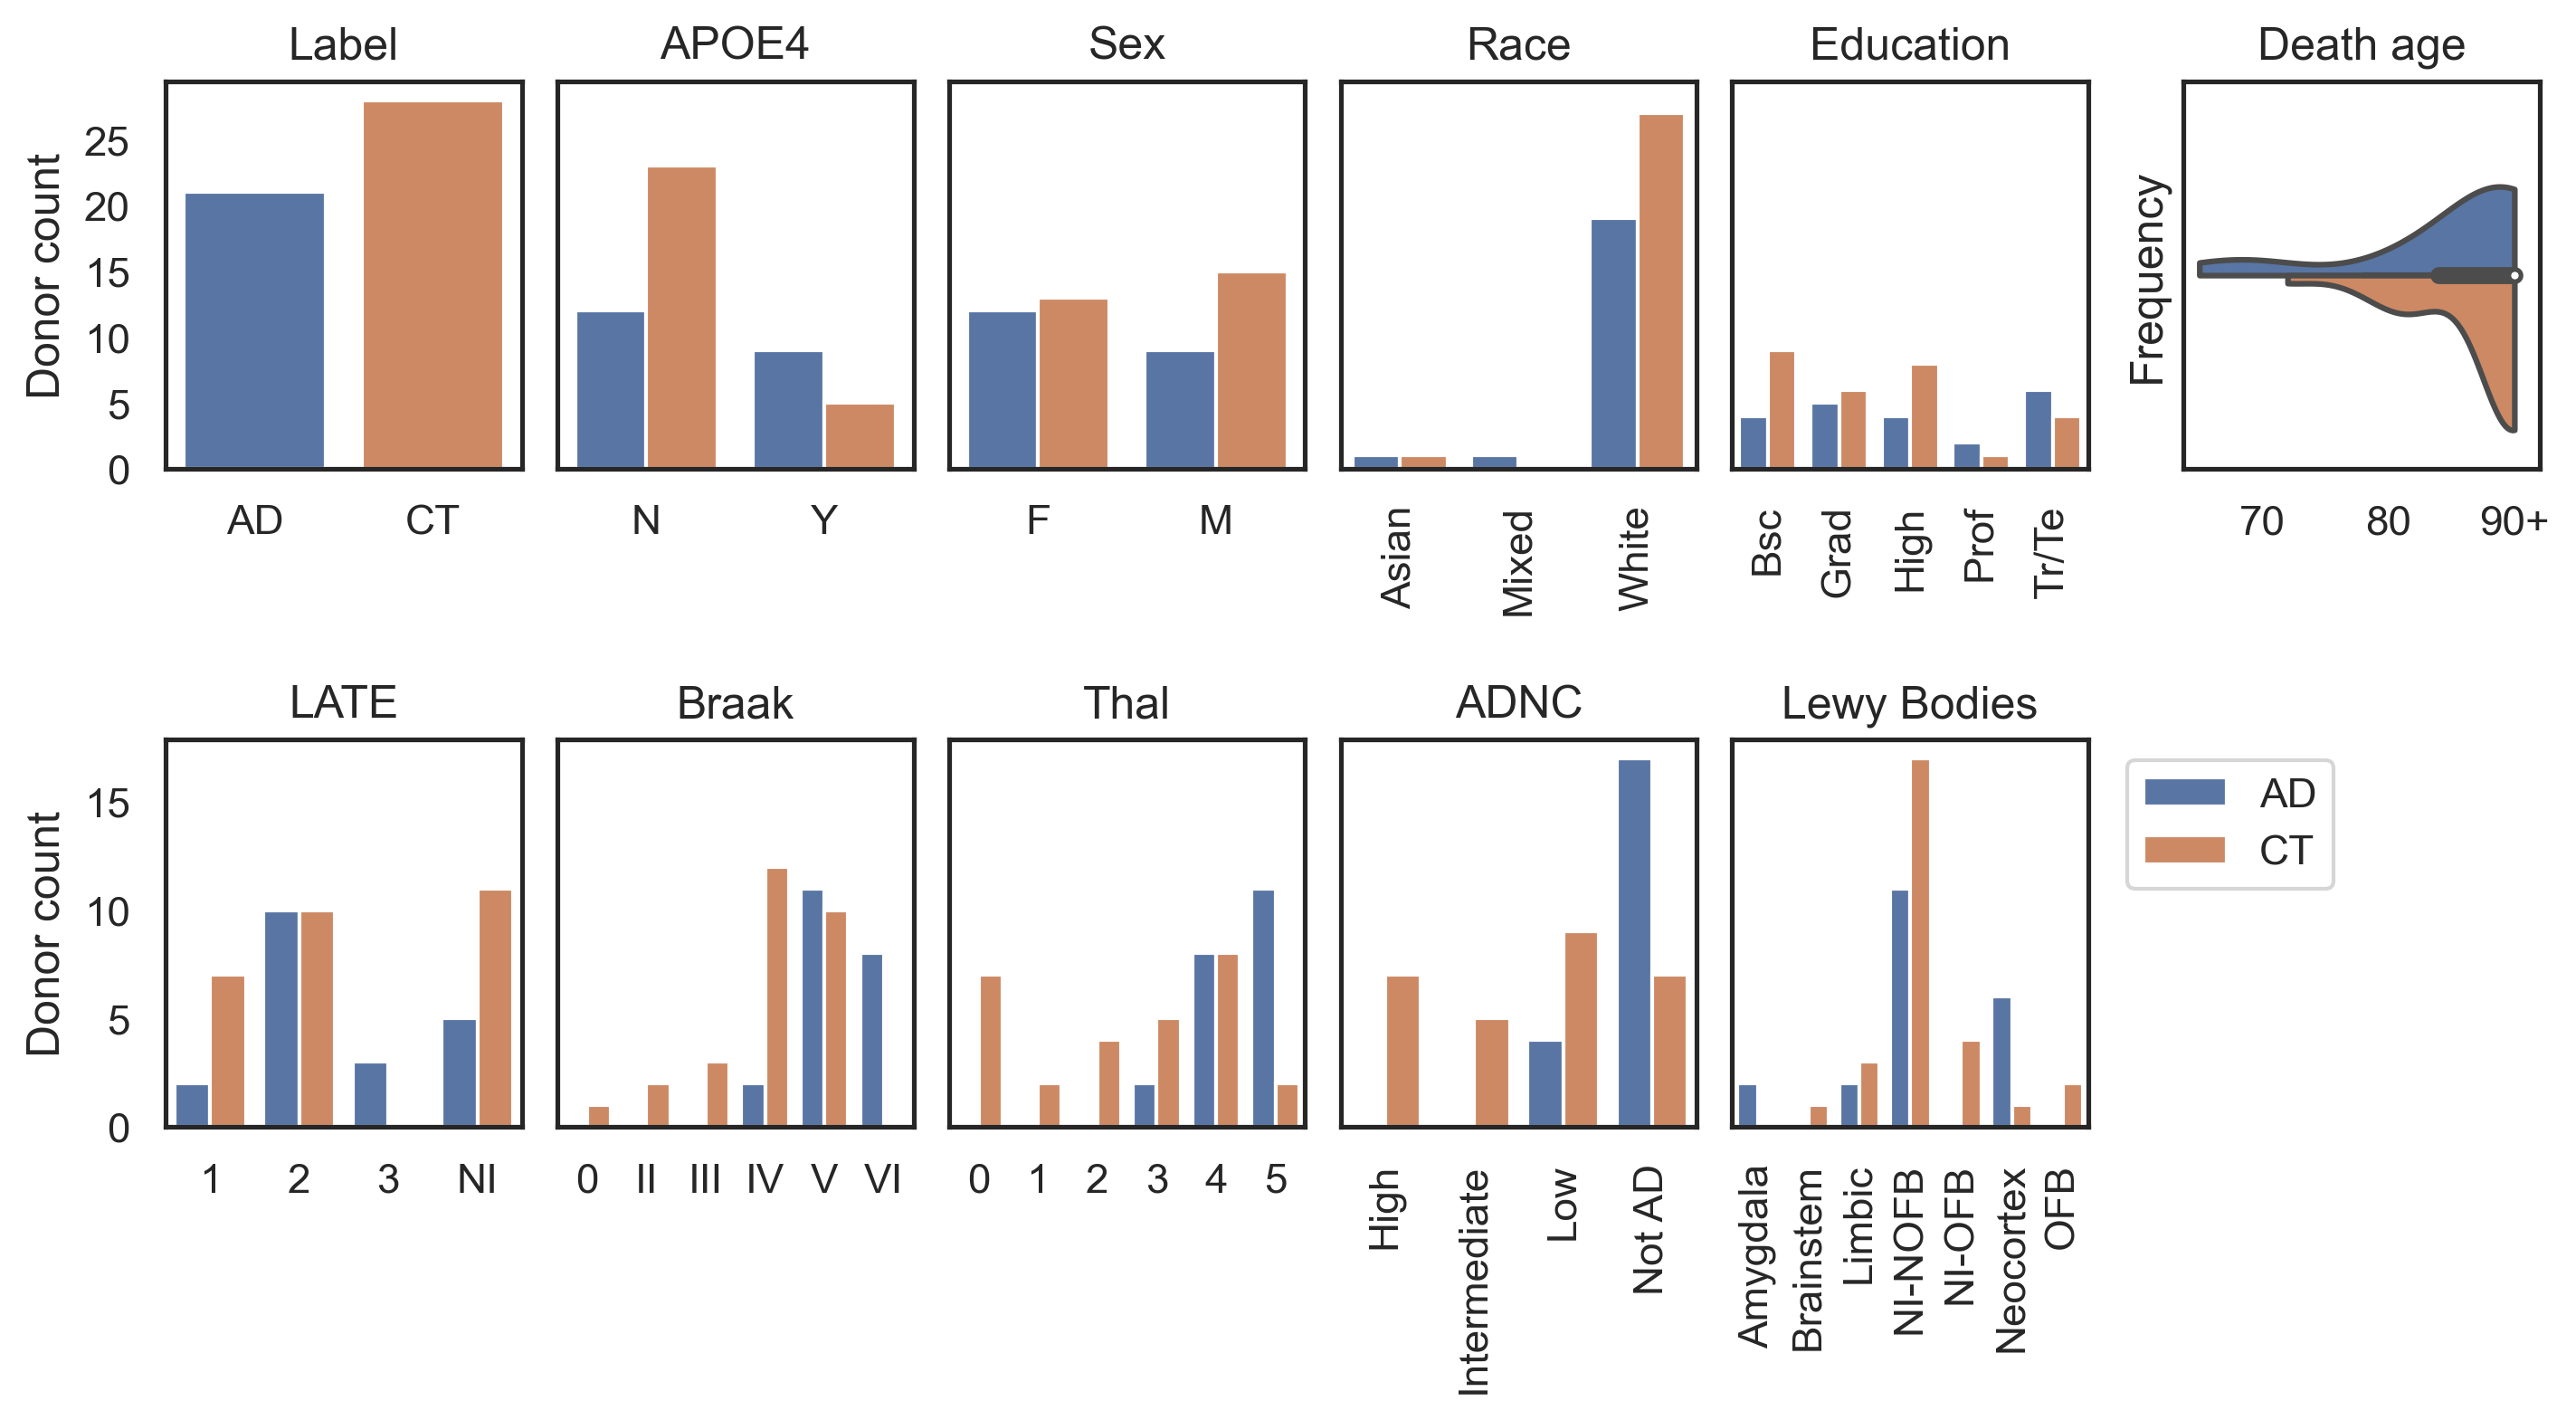

In [13]:
ddf["all"] = ""  # Dummy column required for the violinplot

fig, axs = plt.subplots(
    nrows=2, 
    ncols=(ncols:=6), 
    figsize=(11, 5),
    sharey="row",
    dpi=300,
)

for i, col in enumerate(["Label", "APOE4", "Sex", "Race", "Education", "Death age",
    "LATE", "Braak", "Thal", "ADNC", "Lewy Bodies"]):

    ax = axs[i // ncols, i % ncols]
    
    if col == "ADNC":
        order = ["Not AD", "Low", "Intermediate", "High"]
    elif col == "Death age":
        ax.get_shared_y_axes().remove(ax)  # Don't share this axis
        ax.get_shared_x_axes().remove(ax)
    else:
        order = sorted(ddf[col].value_counts().index)
    
    if col == "Death age":
        sns.violinplot(
            data=ddf,
            ax=ax,
            x=col,
            y="all",
            hue="Label",
            split=True,
            dodge=False,
            # orient="h",
            cut=0,
        )
    else:
        sns.countplot(
            data=ddf,
            ax=ax,
            x=col,
            hue="Label",
            order=order,
            dodge=(col != "Label")
        )
    ax.get_legend().remove()
    
    if col == "Death age":
        ax.set_xticks(
            [64, 70, 80, 90, 92],
            ["", 70, 80, "90+", ""],
            rotation=0,
        )
        ax.set_ylabel("Frequency")
        # ax.yaxis.set_label_position("right")
        # ax.yaxis.tick_right()
        # ax.set_yticks([-1, 0, 1], ["", 0, 1])

    else:
        # If the labels on the xticks are too long, rotate them.
        if any(len(x) > 4 for x in ddf[col].value_counts().index):
            ax.set_xticks(
                range(len(ddf[col].value_counts().index)), 
                sorted(ddf[col].value_counts().index), 
                rotation=90,
            )
        ax.set_ylabel("")
    
    ax.set_xlabel("")
    ax.set_title(col)
    
axs[0, 0].set_yticks([0, 5, 10, 15, 20, 25], [0, 5, 10, 15, 20, 25])
axs[0, 0].set_ylabel("Donor count")
axs[1, 0].set_ylabel("Donor count")

# sns.despine(ax=axs[-1, -1], offset=10, trim=False, left=True, bottom=True, right=True, top=True)
axs[-1, -1].set_axis_off()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Set general space, and move the death age plot to the right a little bit
plt.subplots_adjust(wspace=0.1, hspace=0.7)
pos = axs[0, -1].get_position()
pos.x0 += 0.02
pos.x1 += 0.02
axs[0, -1].set_position(pos)

plt.savefig("../../out/figures/fig_demographics.png", dpi=300, bbox_inches="tight", transparent=True, facecolor="w")
plt.show()